In [1]:
# import matplotlib.pyplot as plt
from os import path, listdir
import os
import monai
from monai.data import (Dataset, list_data_collate, DataLoader, decollate_batch, PersistentDataset)
from monai.transforms import (
    LoadImaged,
    Compose,
    MapTransform,
    Orientationd,
    ToMetaTensord,  # ? same as ensuretyped?
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Spacingd,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations,
    AsDiscrete,
)

from monai.networks.nets import  UNet
from monai.losses import  DiceCELoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.inferers import sliding_window_inference
from monai.optimizers import Novograd, WarmupCosineSchedule

from torch.utils.tensorboard import SummaryWriter

import torch

from tqdm import tqdm

In [2]:
monai.utils.misc.set_determinism(1607)

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

def encode_lgg_hgg(x):
    """Encode LGG and HGG as 0 and 1 for stratification

    Args:
        x (str): LGG or HGG in Dataframe

    Returns:
        int: encodes 0 for LGG and 1 for HGG
    """
    return 0 if x == "LGG" else 1


def train_val_test_dataset(data_path: str):
    """From 100% Cases take 20% cases as Validation.
    Take the remaining 80% cases as training

    Stratification done on data to ensure that the classes are balanced.

    Args:
        data_path (str, optional): Path to Name Mapping File provided by BraTS.

    Returns:
        training, validation, testing: list of case names split into training, validation and testing.
    """
    data = pd.read_csv(data_path)
    data = data[["Grade", "BraTS_2020_subject_ID"]]
    data.Grade = data["Grade"].map(encode_lgg_hgg)
    (training, validation, train_check, val_check,) = train_test_split(
        data.BraTS_2020_subject_ID.to_list(),
        data.Grade.to_numpy(),
        test_size=0.2,
        random_state=42,
        stratify=data.Grade.to_numpy(),
        shuffle=True,
    )

    print(
        f"""
    Total Samples = {len(training)+len(validation)}\n
    Ratio of LGG:HGG in {len(training)} Training Samples:
    \t Ratio = {np.count_nonzero(train_check==0)/np.count_nonzero(train_check==1):.2f}\n

    Ratio of LGG:HGG in {len(validation)} Validation Samples:
    \t Ratio = {np.count_nonzero(val_check==0)/np.count_nonzero(val_check==1):.2f}\n
    
    """
    )

    return (training, validation)

In [6]:
# Prepare list of All training Cases
TRAINING_DATASET_PATH = r"./MICCAI_BraTS2020_TrainingData/"
NAME_MAPPING = r"./MICCAI_BraTS2020_TrainingData/name_mapping.csv"

# Function returns names of cases to be used
train_cases, val_cases = train_val_test_dataset(NAME_MAPPING)


    Total Samples = 369

    Ratio of LGG:HGG in 295 Training Samples:
    	 Ratio = 0.26


    Ratio of LGG:HGG in 74 Validation Samples:
    	 Ratio = 0.25

    
    


In [7]:
train_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{case}_seg.nii.gz"
        ),
    }
    for case in train_cases
]

val_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{case}_seg.nii.gz"
        ),
    }
    for case in val_cases
]


In [8]:
class ConvertLabelsIntoOneHotd(MapTransform):
    """Takes input tensor of segmentation which contains
    values in set (0,1,2,4) where\n
    0 -> Background/Normal\n
    1 -> Non- Enhancing Tumor Core\n
    2 -> Edema\n
    4 -> Enhancing tumor core\n

    and returns a one hot encoded 3 channel tensor where
    1st Channel -> Whole tumor (1,2 and 4)
    2nd Channel -> Tumor Core (1 and 4)
    3rd Channel -> Enhancing Tumor core (4)
    """

    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                torch.logical_or(
                    torch.logical_or(data_dict[key] == 1, data_dict[key] == 2),
                    data_dict[key] == 4,
                ),  # Whole Tumor
                torch.logical_or(
                    data_dict[key] == 1, data_dict[key] == 4
                ),  # Tumor Core
                data_dict[key] == 4,  # Enhancing Core
            ]
            data_dict[key] = torch.stack(one_hot_encode_array, axis=0).astype(
                torch.float32
            )
        return data_dict


transform_no_norm = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        ToMetaTensord(keys=["image", "seg"]),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        #! Training Dataset Already set to Pixel Dimension of 1mm^3
    ]
)

normalise_mri = NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True)


In [12]:
transform_training_dataset = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image"]),
            # ConvertLabelsIntoOneHotd(keys="seg"),
            # ToMetaTensord(["image", "seg"]),
            # Orientationd(keys=["image", "seg"], axcodes="RAS"),
            # NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            # RandCropByPosNegLabeld(
            #     keys=["image", "seg"],
            #     spatial_size=(128, 128, 128),
            #     label_key="seg",
            #     neg=0,
            #     num_samples=2,
            # ),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
            # RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            # RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )


In [13]:
result_no_brats = transform_training_dataset(train_cases[0])

In [14]:
transform_training_dataset = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image"]),
            ConvertLabelsIntoOneHotd(keys="seg"),
            # ToMetaTensord(["image", "seg"]),
            # Orientationd(keys=["image", "seg"], axcodes="RAS"),
            # NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            # RandCropByPosNegLabeld(
            #     keys=["image", "seg"],
            #     spatial_size=(128, 128, 128),
            #     label_key="seg",
            #     neg=0,
            #     num_samples=2,
            # ),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
            # RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            # RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )

In [15]:
result_brats = transform_training_dataset(train_cases[0])

In [21]:
result_no_brats["seg"][...,75]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

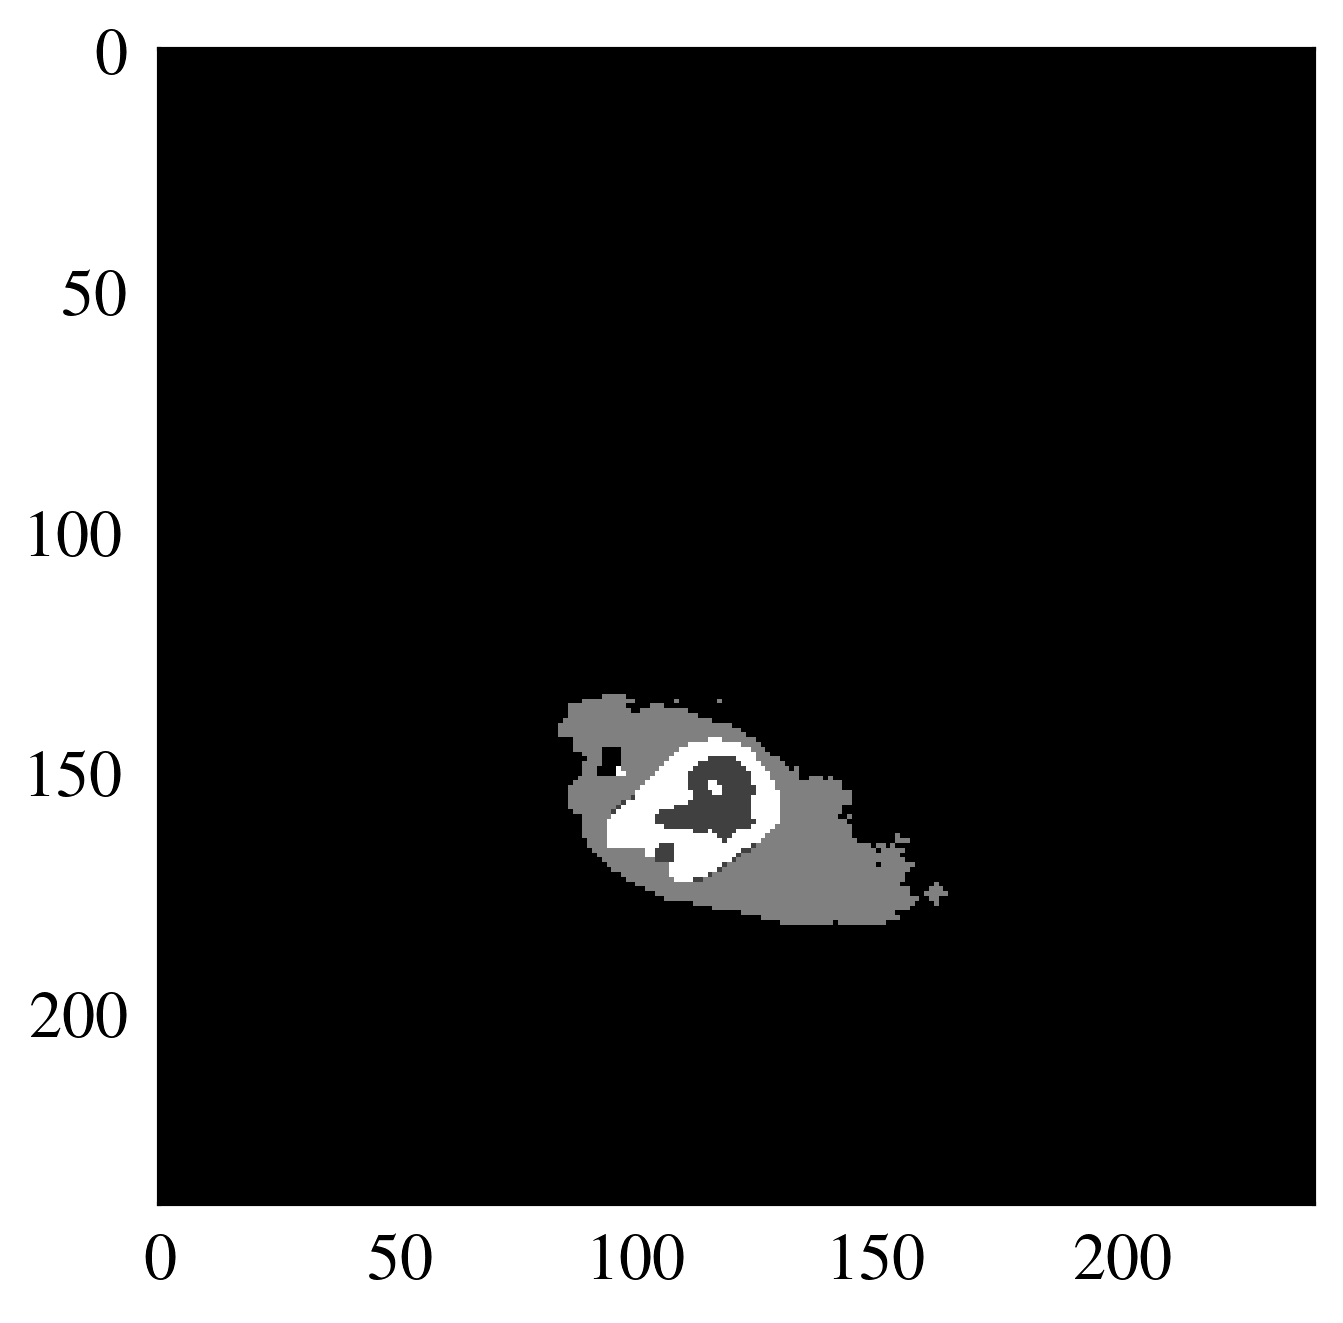

In [25]:
plt.imshow(result_no_brats["seg"][...,70],cmap='gray')

In [10]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])

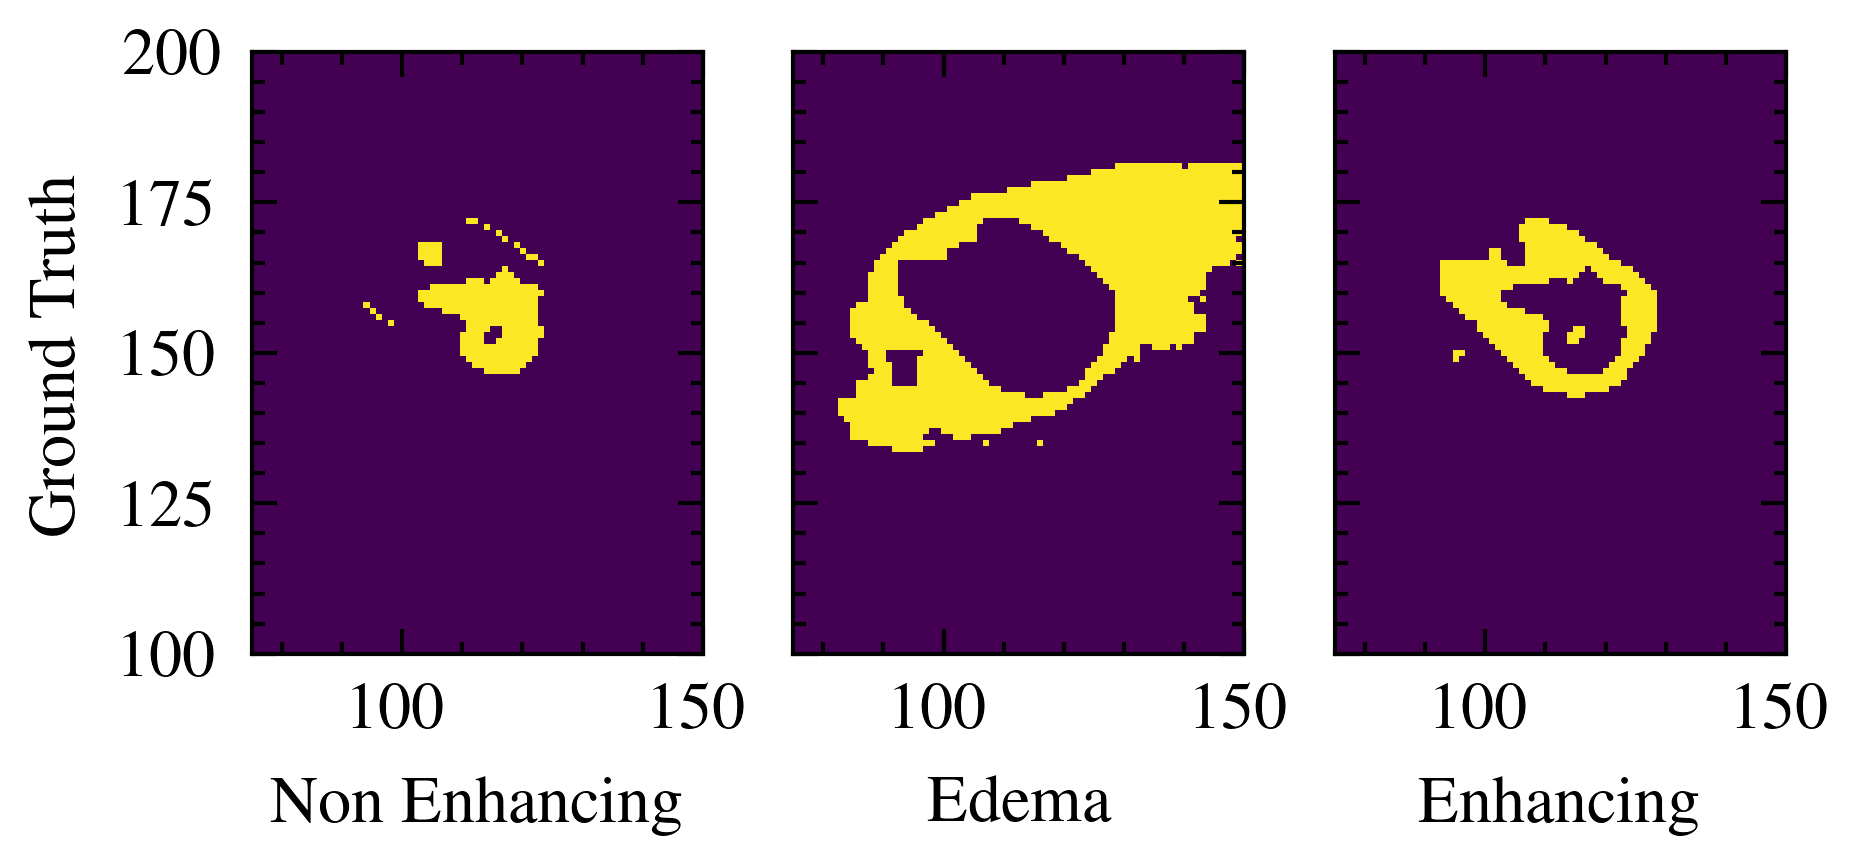

In [38]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True)
ax[0].set_ylim(100,200)
ax[0].set_xlim(75,150)

ax[0].set_xlabel("Non Enhancing")
ax[1].set_xlabel("Edema")
ax[2].set_xlabel("Enhancing")

ax[0].set_ylabel("Ground Truth")
ax[0].imshow(result_no_brats["seg"][...,70]==1)
ax[1].imshow(result_no_brats["seg"][...,70]==2)
ax[2].imshow(result_no_brats["seg"][...,70]==4)



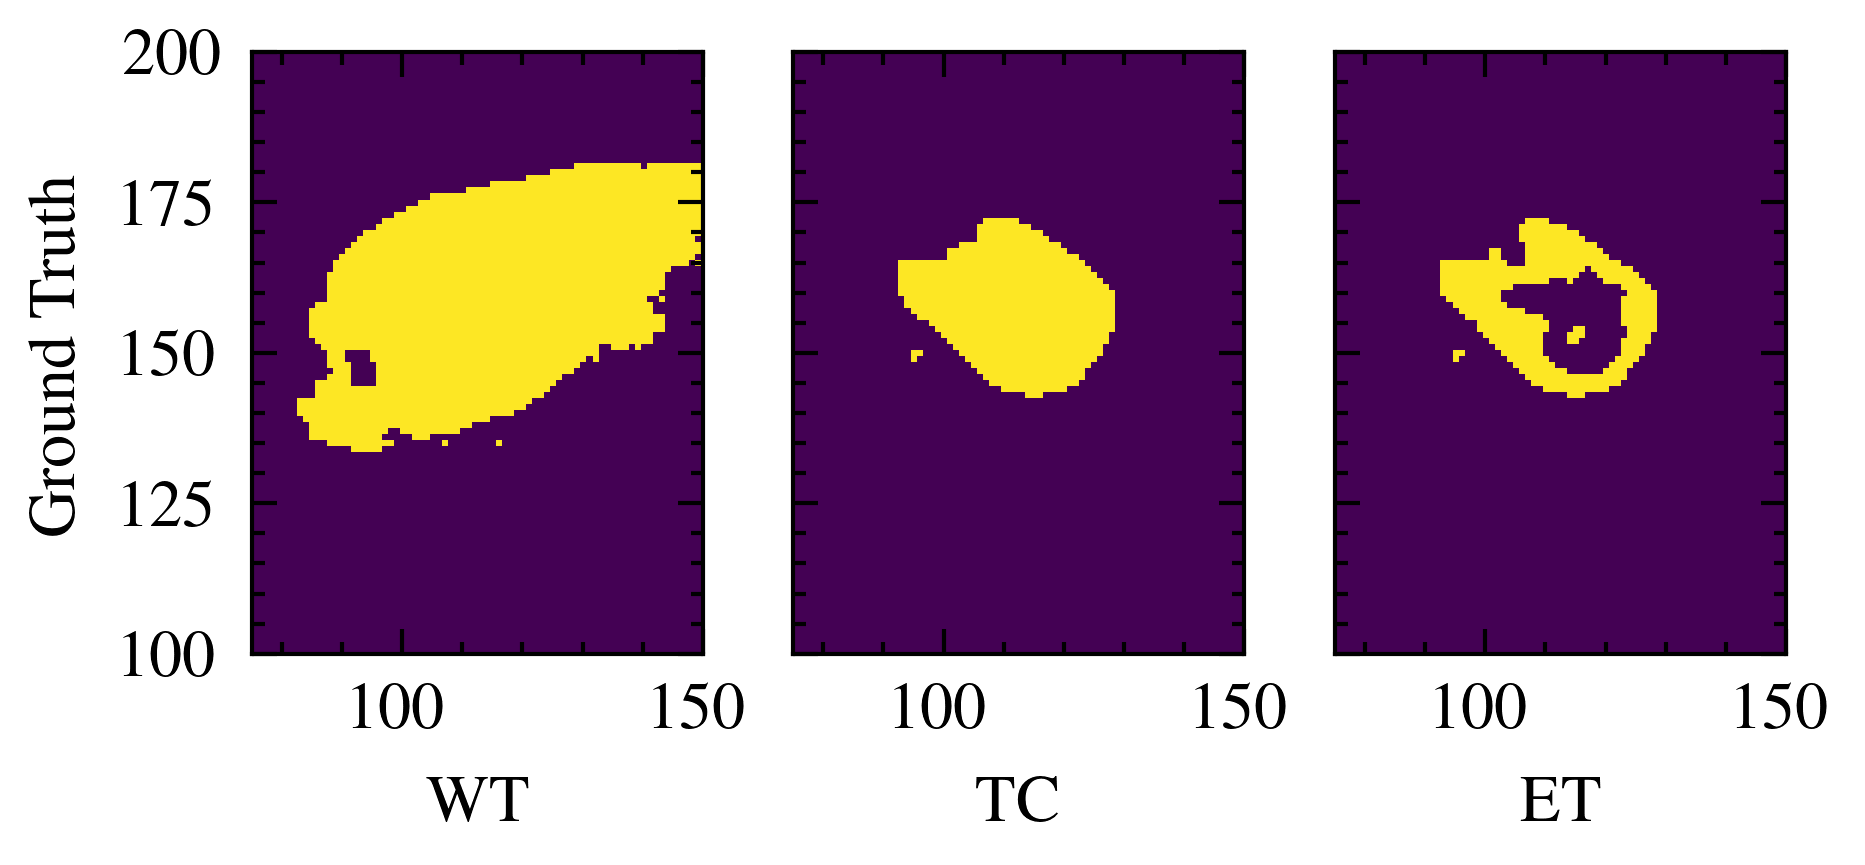

In [56]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True)
ax[0].set_ylim(100,200)
ax[0].set_xlim(75,150)



ax[0].set_xlabel("WT")
ax[1].set_xlabel("TC")
ax[2].set_xlabel("ET")

ax[0].set_ylabel("Ground Truth")
ax[0].imshow(result_brats["seg"][0][...,70])
ax[1].imshow(result_brats["seg"][1][...,70])
value_range = ax[2].imshow(result_brats["seg"][2][...,70])

In [49]:
a = torch.rand(1,1)

In [50]:
a.numpy()

array([[0.51674044]], dtype=float32)

In [57]:
transform_training_dataset = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image"]),
            ConvertLabelsIntoOneHotd(keys="seg"),
            # ToMetaTensord(["image", "seg"]),
            # Orientationd(keys=["image", "seg"], axcodes="RAS"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            # RandCropByPosNegLabeld(
            #     keys=["image", "seg"],
            #     spatial_size=(128, 128, 128),
            #     label_key="seg",
            #     neg=0,
            #     num_samples=2,
            # ),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
            # RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
            # RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            # RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )

In [58]:
result_normalised = transform_training_dataset(train_cases[0])

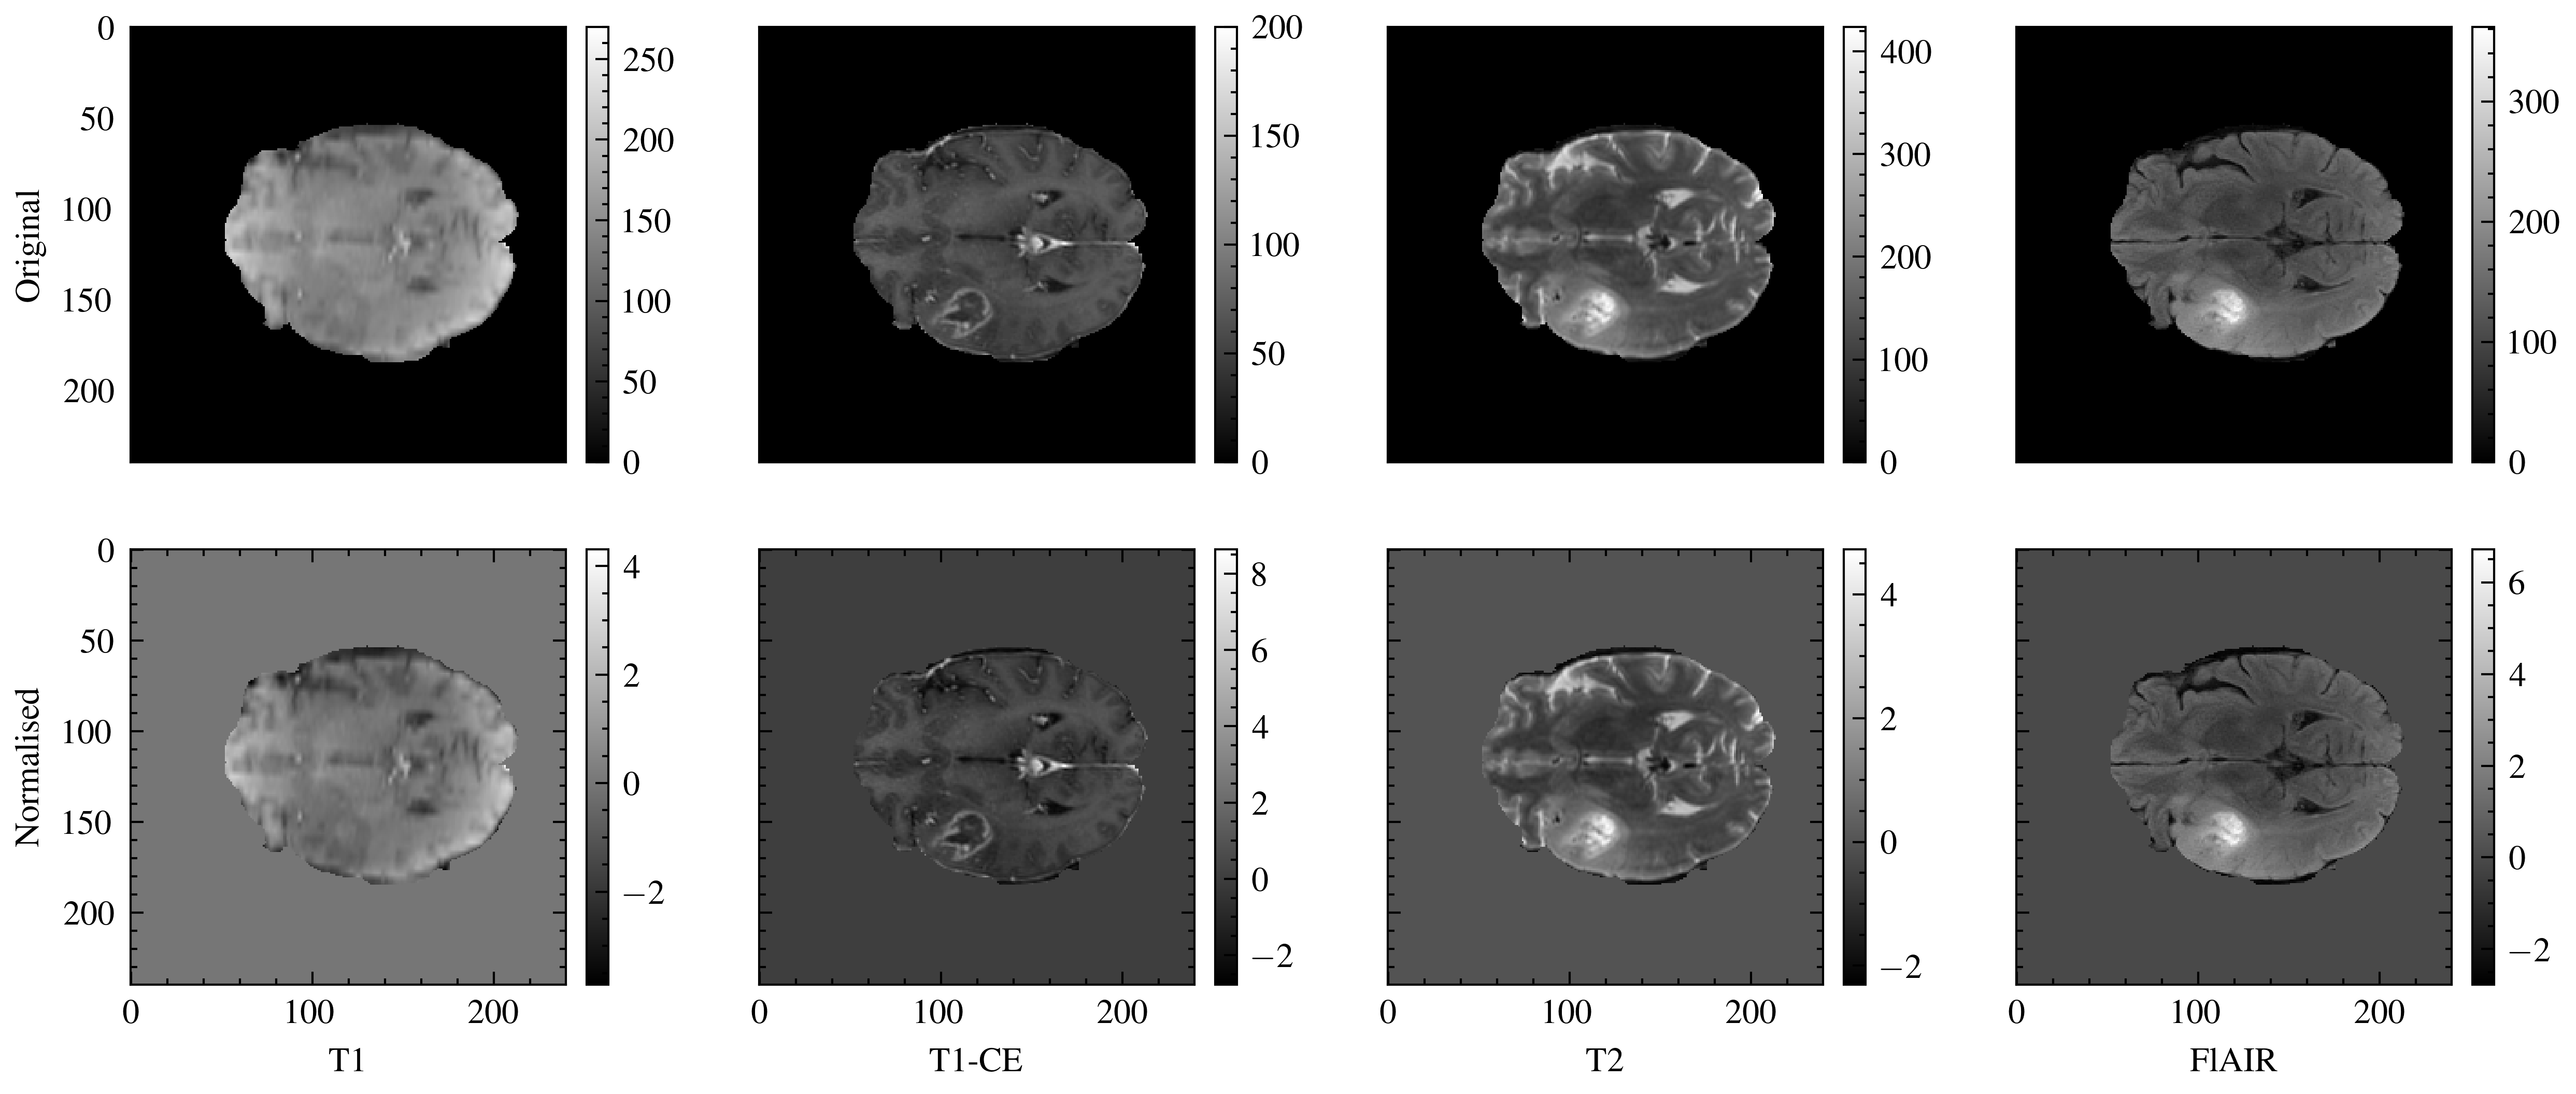

In [77]:
fig , ax = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,4))





ax[1,0].set_xlabel("T1")
ax[1,1].set_xlabel("T1-CE")
ax[1,2].set_xlabel("T2")
ax[1,3].set_xlabel("FlAIR")
ax[0,0].set_ylabel("Original")
ax[1,0].set_ylabel("Normalised")


c1 = ax[0,0].imshow(result_brats["image"][0][...,70],cmap='gray')
fig.colorbar(c1,fraction=0.046, pad=0.04)
c2 = ax[0,1].imshow(result_brats["image"][1][...,70],cmap='gray')
fig.colorbar(c2,fraction=0.046, pad=0.04)
c3 = ax[0,2].imshow(result_brats["image"][2][...,70],cmap='gray')
fig.colorbar(c3,fraction=0.046, pad=0.04)
c4  = ax[0,3].imshow(result_brats["image"][3][...,70],cmap='gray')
fig.colorbar(c4,fraction=0.046, pad=0.04)


c5 = ax[1,0].imshow(result_normalised["image"][0][...,70],cmap='gray')
fig.colorbar(c5,fraction=0.046, pad=0.04)
c6 = ax[1,1].imshow(result_normalised["image"][1][...,70],cmap='gray')
fig.colorbar(c6,fraction=0.046, pad=0.04)
c7 = ax[1,2].imshow(result_normalised["image"][2][...,70],cmap='gray')
fig.colorbar(c7,fraction=0.046, pad=0.04)
c8 = ax[1,3].imshow(result_normalised["image"][3][...,70],cmap='gray')
fig.colorbar(c8,fraction=0.046, pad=0.04)


In [101]:
transform_training_dataset = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image"]),
            ConvertLabelsIntoOneHotd(keys="seg"),
            ToMetaTensord(["image", "seg"]),
            Orientationd(keys=["image", "seg"], axcodes="RAS"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            RandCropByPosNegLabeld(
                keys=["image", "seg"],
                spatial_size=(128, 128, 128),
                label_key="seg",
                neg=0,
                num_samples=2,
            ),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
            # RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            # RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )

In [102]:
result_crop = transform_training_dataset(train_cases[2])

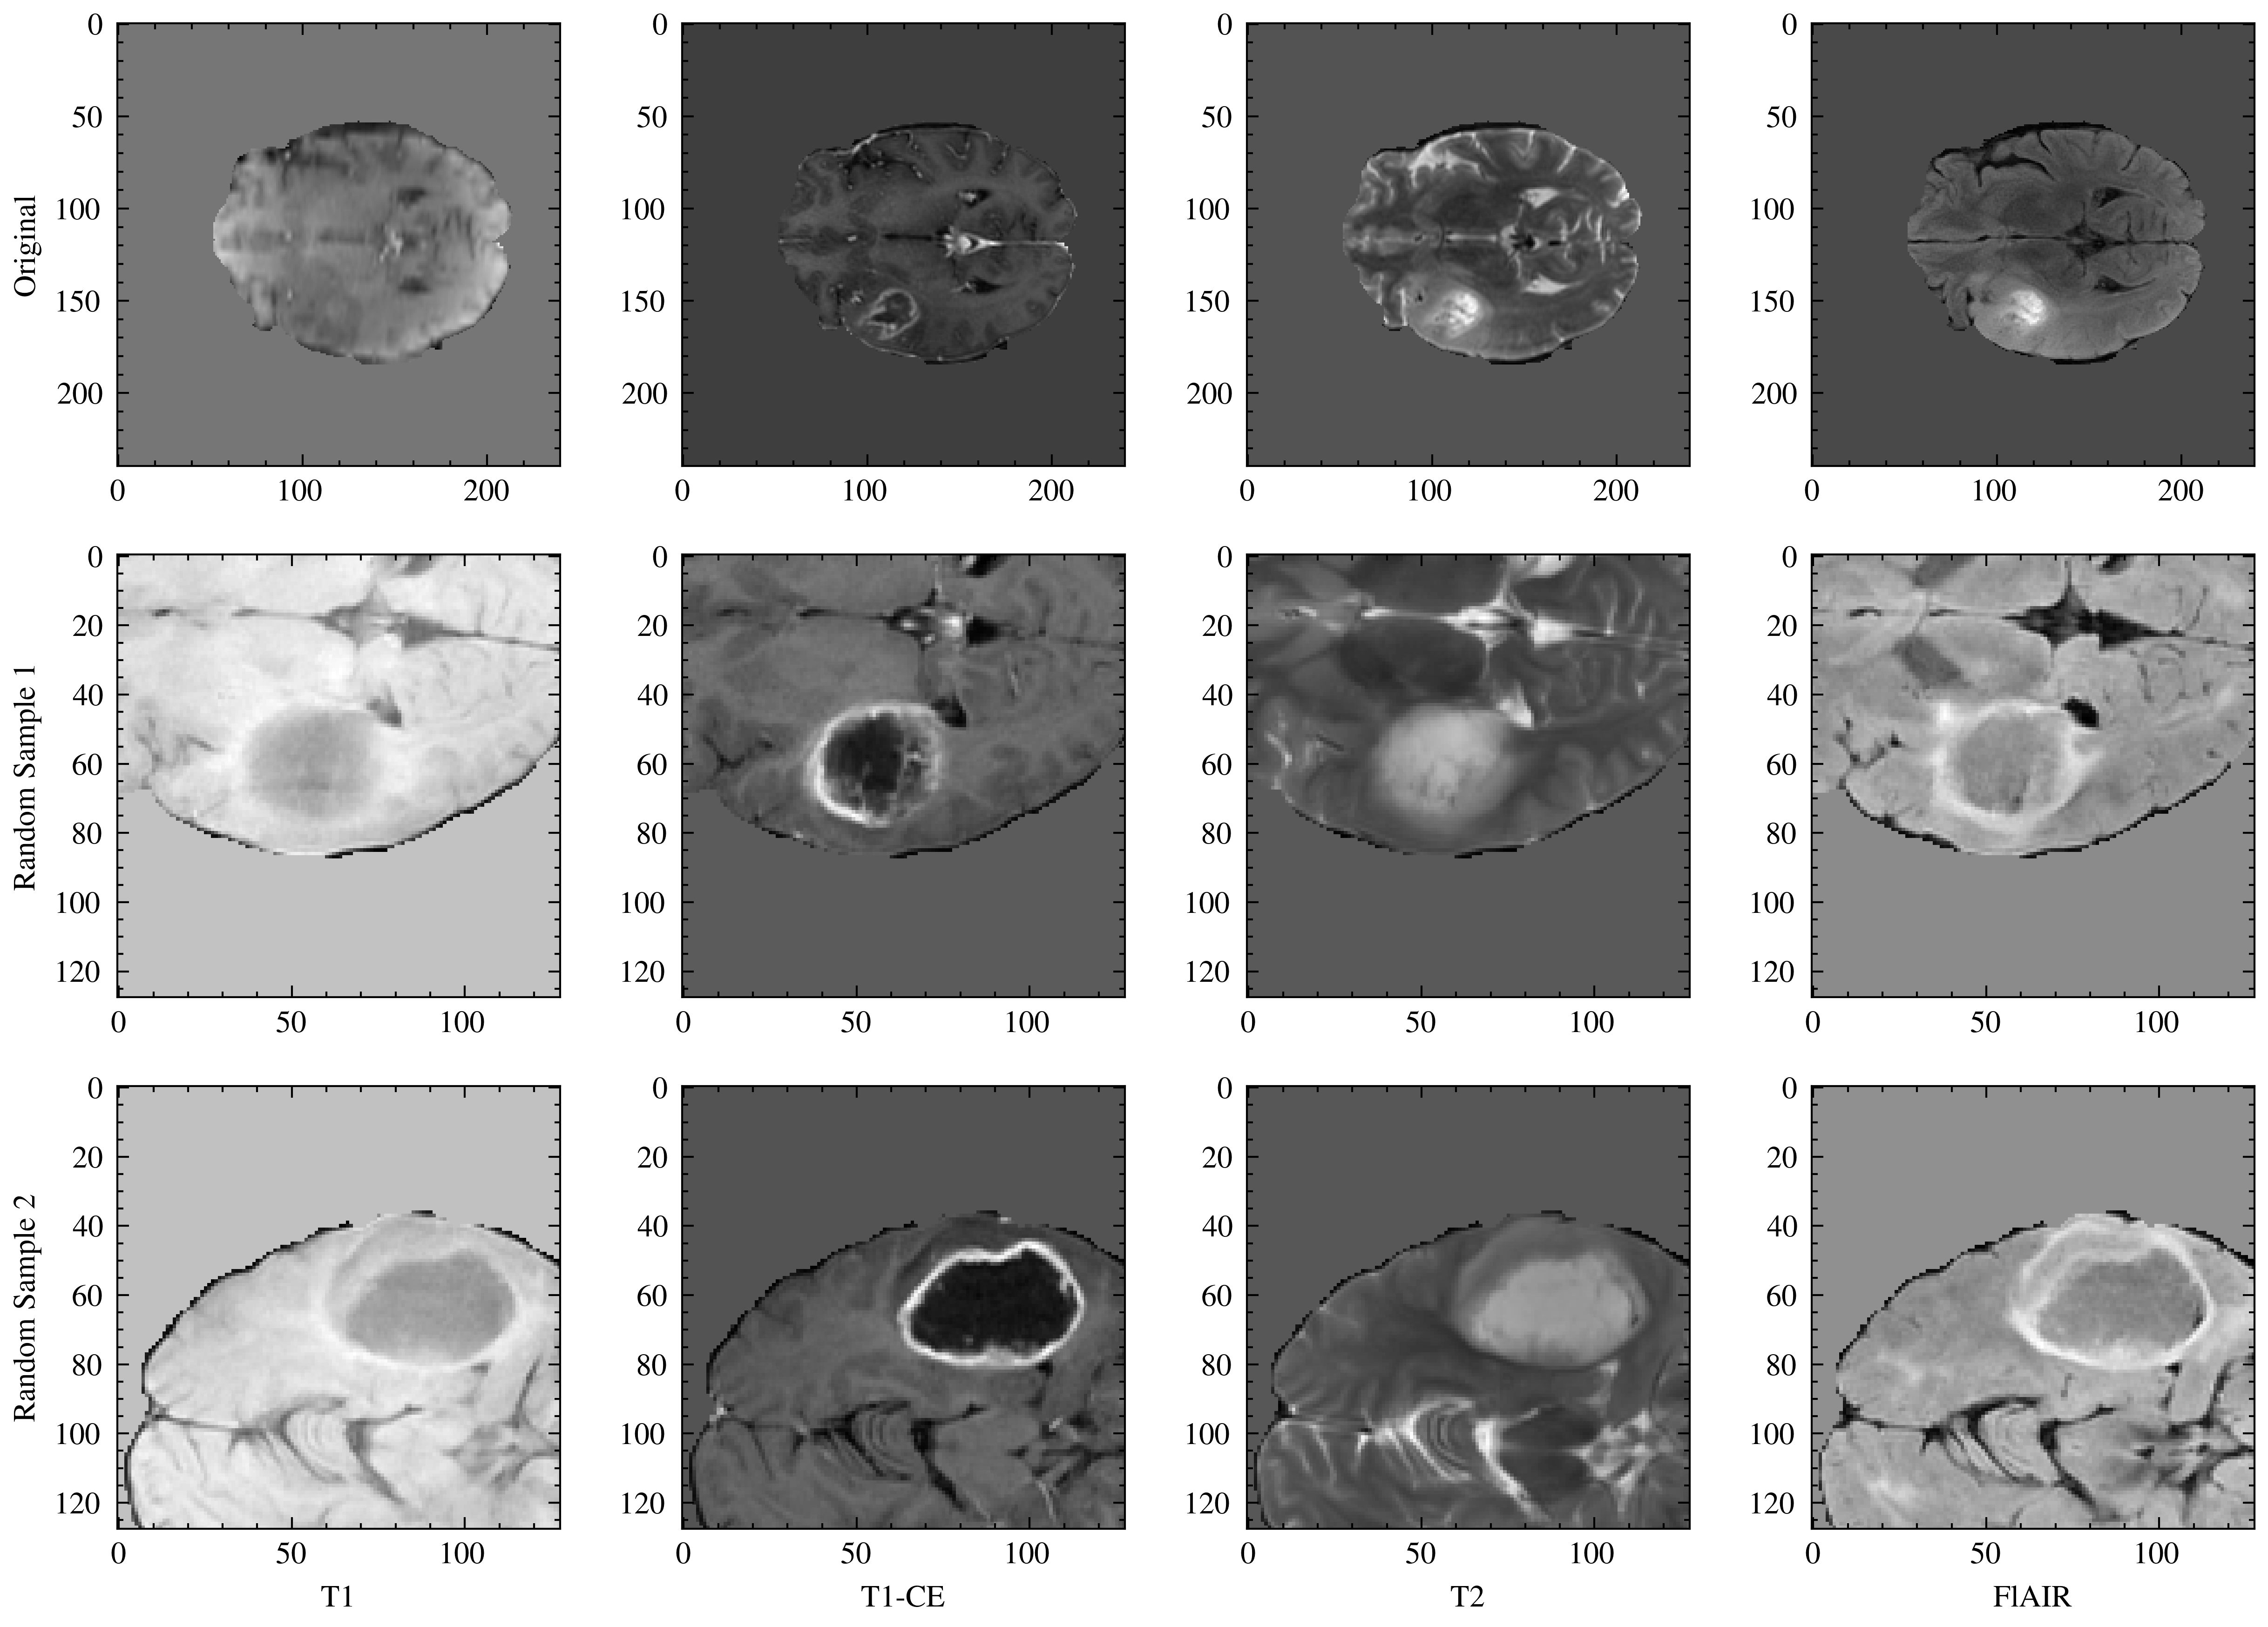

In [104]:
fig , ax = plt.subplots(3,4,figsize=(10,7))





ax[2,0].set_xlabel("T1")
ax[2,1].set_xlabel("T1-CE")
ax[2,2].set_xlabel("T2")
ax[2,3].set_xlabel("FlAIR")


ax[0,0].set_ylabel("Original")
ax[1,0].set_ylabel("Random Sample 1")
ax[2,0].set_ylabel("Random Sample 2")


# originals

c5 = ax[0,0].imshow(result_normalised["image"][0][...,70],cmap='gray')
c6 = ax[0,1].imshow(result_normalised["image"][1][...,70],cmap='gray')
c7 = ax[0,2].imshow(result_normalised["image"][2][...,70],cmap='gray')
c8 = ax[0,3].imshow(result_normalised["image"][3][...,70],cmap='gray')

# crop 1
c5 = ax[1,0].imshow(result_crop[0]["image"][0][...,70],cmap='gray')
c6 = ax[1,1].imshow(result_crop[0]["image"][1][...,70],cmap='gray')
c7 = ax[1,2].imshow(result_crop[0]["image"][2][...,70],cmap='gray')
c8 = ax[1,3].imshow(result_crop[0]["image"][3][...,70],cmap='gray')

# crop 2
c5 = ax[2,0].imshow(result_crop[1]["image"][0][...,70],cmap='gray')
c6 = ax[2,1].imshow(result_crop[1]["image"][1][...,70],cmap='gray')
c7 = ax[2,2].imshow(result_crop[1]["image"][2][...,70],cmap='gray')
c8 = ax[2,3].imshow(result_crop[1]["image"][3][...,70],cmap='gray')


In [105]:
transform_training_dataset = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image"]),
            ConvertLabelsIntoOneHotd(keys="seg"),
            ToMetaTensord(["image", "seg"]),
            Orientationd(keys=["image", "seg"], axcodes="RAS"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            RandCropByPosNegLabeld(
                keys=["image", "seg"],
                spatial_size=(128, 128, 128),
                label_key="seg",
                neg=0,
                num_samples=2,
            ),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
            RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )

In [106]:
result_shift_scale = transform_training_dataset(train_cases[2])

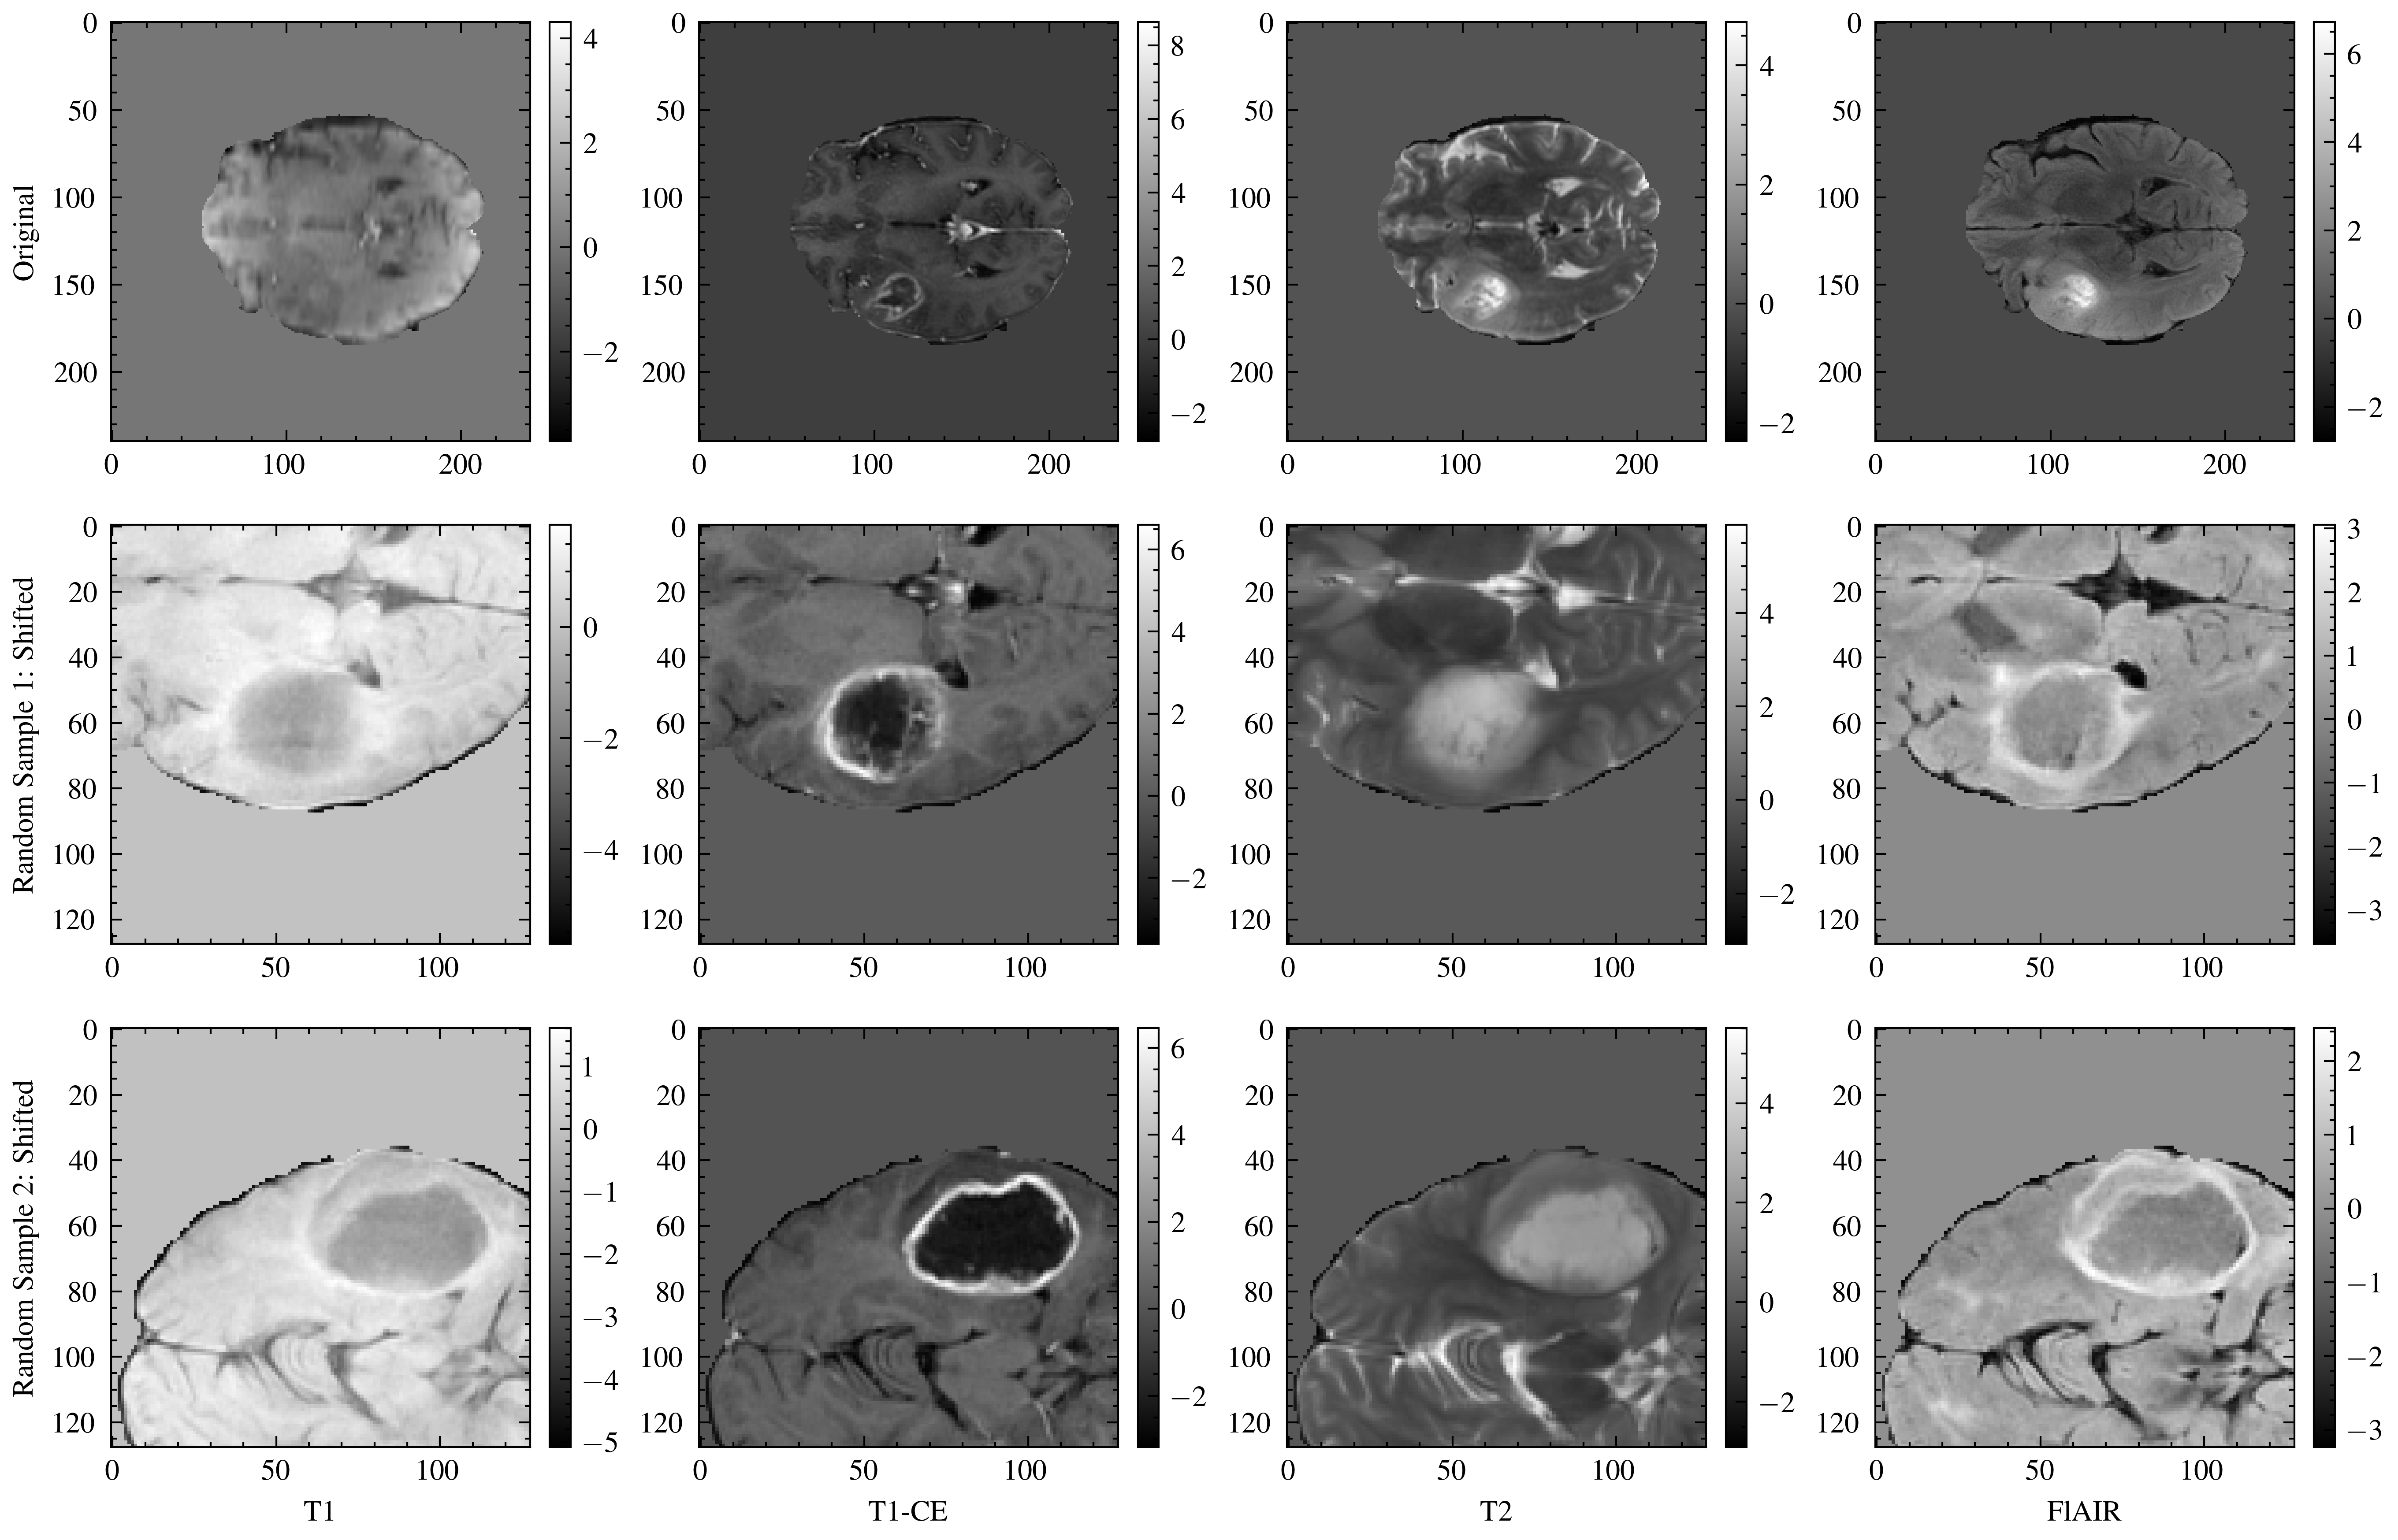

In [109]:
fig , ax = plt.subplots(3,4,figsize=(11,7))





ax[2,0].set_xlabel("T1")
ax[2,1].set_xlabel("T1-CE")
ax[2,2].set_xlabel("T2")
ax[2,3].set_xlabel("FlAIR")


ax[0,0].set_ylabel("Original")
ax[1,0].set_ylabel("Random Sample 1: Shifted")
ax[2,0].set_ylabel("Random Sample 2: Shifted")


# originals

c5 = ax[0,0].imshow(result_normalised["image"][0][...,70],cmap='gray')
fig.colorbar(c5,fraction=0.046, pad=0.04)

c6 = ax[0,1].imshow(result_normalised["image"][1][...,70],cmap='gray')
fig.colorbar(c6,fraction=0.046, pad=0.04)

c7 = ax[0,2].imshow(result_normalised["image"][2][...,70],cmap='gray')
fig.colorbar(c7,fraction=0.046, pad=0.04)

c8 = ax[0,3].imshow(result_normalised["image"][3][...,70],cmap='gray')
fig.colorbar(c8,fraction=0.046, pad=0.04)

# crop 1
c5 = ax[1,0].imshow(result_shift_scale[0]["image"][0][...,70],cmap='gray')
c6 = ax[1,1].imshow(result_shift_scale[0]["image"][1][...,70],cmap='gray')
c7 = ax[1,2].imshow(result_shift_scale[0]["image"][2][...,70],cmap='gray')
c8 = ax[1,3].imshow(result_shift_scale[0]["image"][3][...,70],cmap='gray')
fig.colorbar(c5,fraction=0.046, pad=0.04)
fig.colorbar(c6,fraction=0.046, pad=0.04)
fig.colorbar(c7,fraction=0.046, pad=0.04)
fig.colorbar(c8,fraction=0.046, pad=0.04)

# crop 2
c5 = ax[2,0].imshow(result_shift_scale[1]["image"][0][...,70],cmap='gray')
c6 = ax[2,1].imshow(result_shift_scale[1]["image"][1][...,70],cmap='gray')
c7 = ax[2,2].imshow(result_shift_scale[1]["image"][2][...,70],cmap='gray')
c8 = ax[2,3].imshow(result_shift_scale[1]["image"][3][...,70],cmap='gray')
fig.colorbar(c5,fraction=0.046, pad=0.04)
fig.colorbar(c6,fraction=0.046, pad=0.04)
fig.colorbar(c7,fraction=0.046, pad=0.04)
fig.colorbar(c8,fraction=0.046, pad=0.04)


In [3]:
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    strides=(2, 2, 2),
    channels=[16,32,64,128],
    num_res_units=2,
).to('cpu')
optimizer = Novograd(model.parameters(), weight_decay=0.0001)

In [47]:
1e-10 * 0.001

1e-13

In [5]:
lr_scheduler = WarmupCosineSchedule(
    optimizer,
    warmup_steps=int(100 / 10),
    warmup_multiplier=1e-10,
    t_total=100,
)

In [8]:
lr = []
for i in range(100):
    lr.append(lr_scheduler.get_last_lr())
    lr_scheduler.step()


c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[10.001,
 10.00099969541351,
 10.00099878202513,
 10.000997260947685,
 10.00099513403437,
 10.000992403876506,
 10.000989073800367,
 10.000985147863139,
 10.00098063084797,
 10.000975528258147,
 10.000969846310394,
 10.000963591927283,
 10.000956772728822,
 10.000949397023149,
 10.000941473796429,
 10.000933012701893,
 10.000924024048079,
 10.000914518786278,
 10.000904508497188,
 10.000894005376804,
 10.00088302222156,
 10.00087157241274,
 10.00085966990017,
 10.000847329185229,
 10.00083456530318,
 10.000821393804843,
 10.000807830737664,
 10.000793892626147,
 10.000779596451736,
 10.000764959632116,
 10.00075,
 10.000734735781393,
 10.000719185573395,
 10.000703368321538,
 10.000687303296708,
 10.000671010071663,
 10.000654508497188,
 10.000637818677909,
 10.0006209609478,
 10.000603955845408,
 10.000586824088833,
 10.00056958655048,
 10.000552264231635,
 10.000534878236872,
 10.00051744974835,
 10.0005,
 10.000482550251649,
 10.000465121763128,
 10.000447735768367,
 10.000430413449

Text(40, 0.0009449999999955, 'Cosine Annealing')

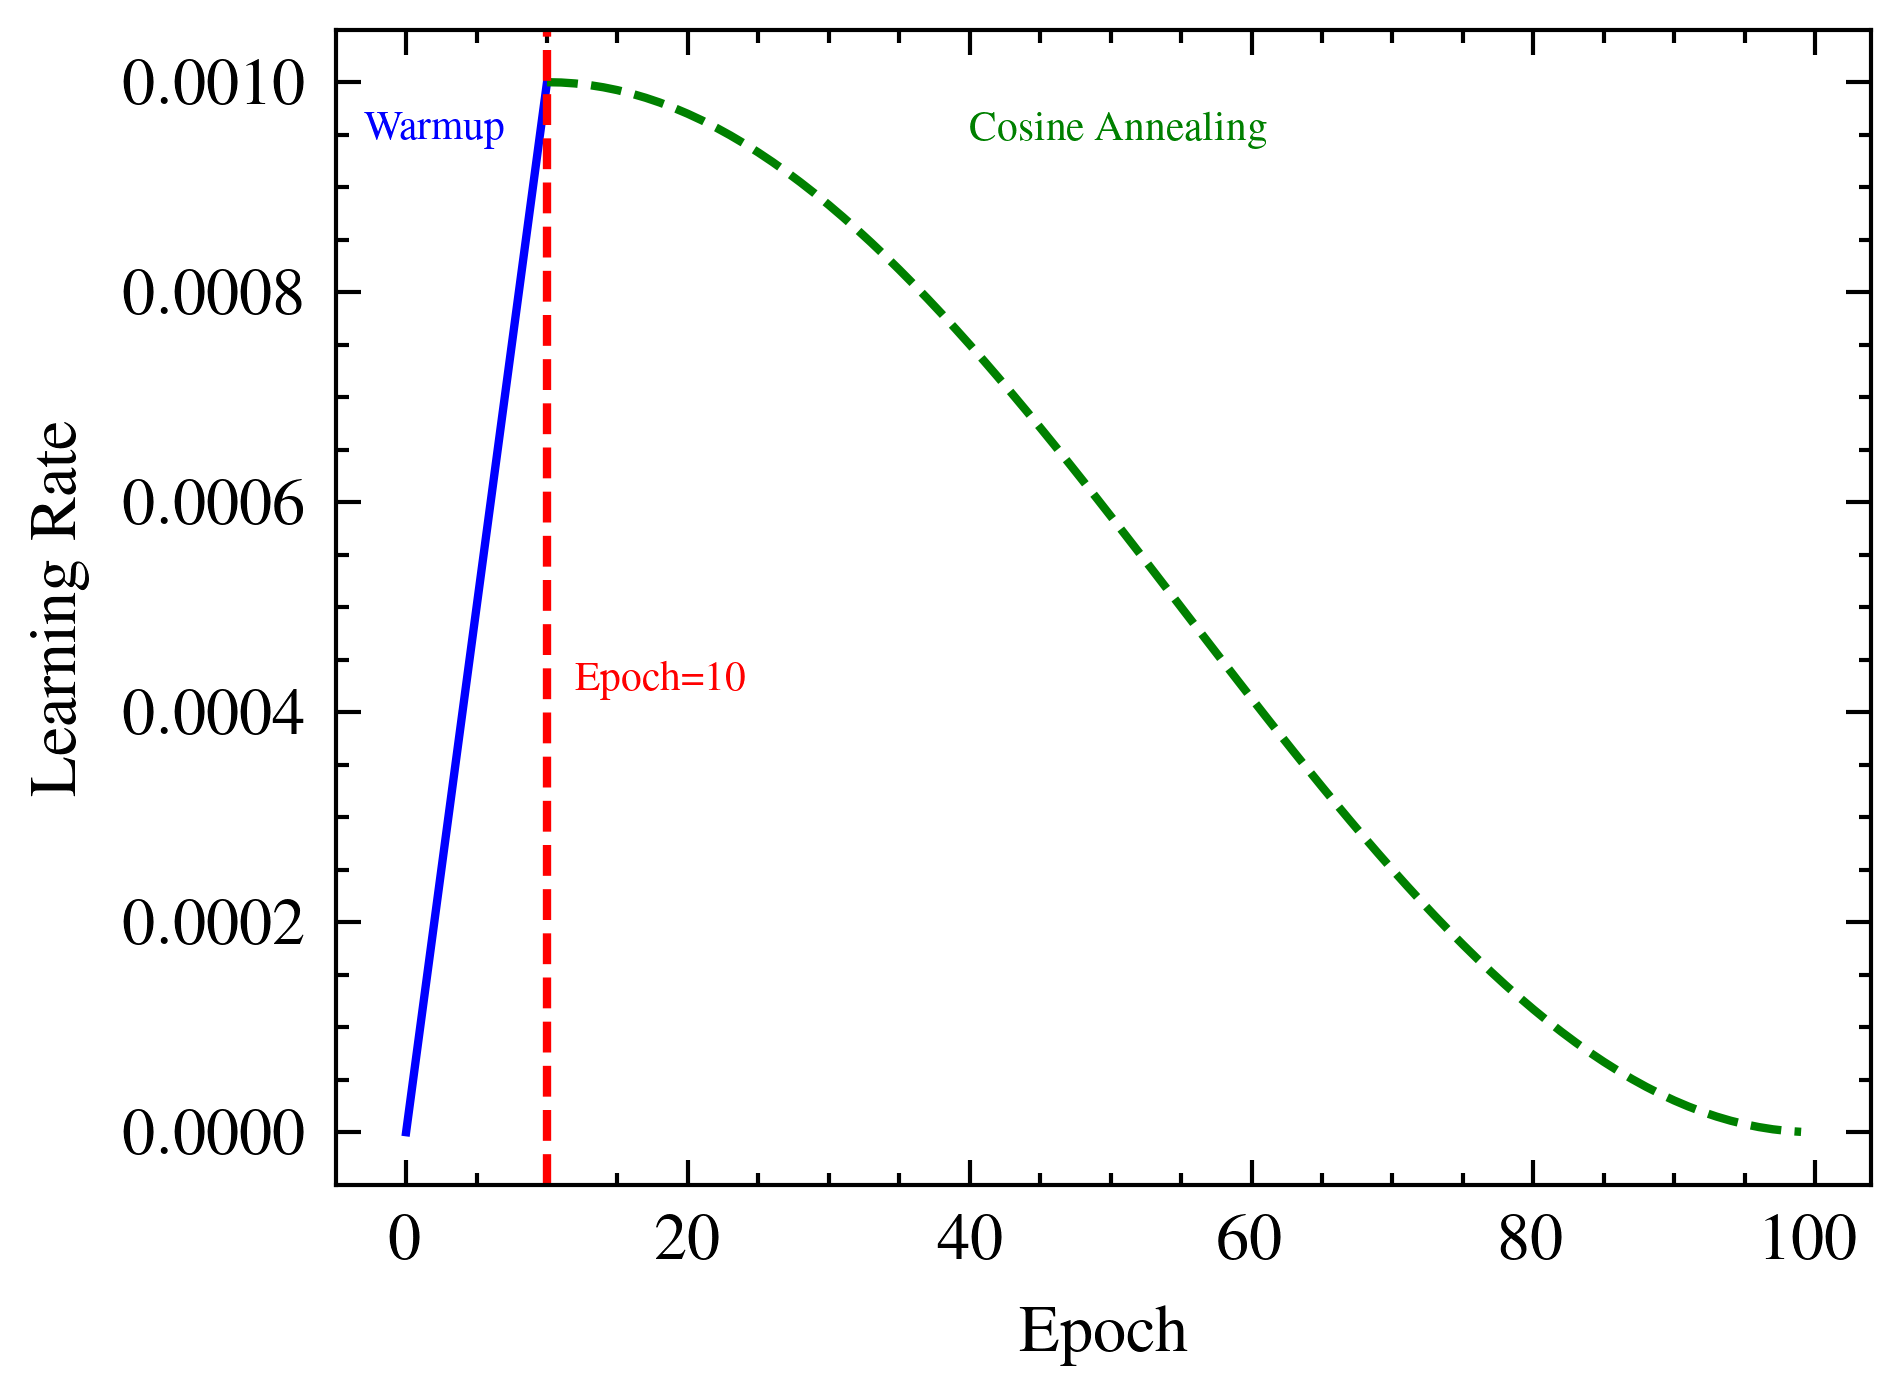

In [46]:
fig , ax = plt.subplots()
ax.plot(lr[:11],color='blue')
ax.plot(range(10,100),lr[10:],color='green')
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.axvline(x=10,color='red',linestyle='--')
ax.text(12, ax.get_ylim()[1] * 0.40, 'Epoch=10', fontsize=5, color='red')
ax.text(-3, ax.get_ylim()[1] * 0.90, 'Warmup', fontsize=5, color='blue')
ax.text(40, ax.get_ylim()[1] * 0.90, 'Cosine Annealing', fontsize=5, color='green')